# get token importance values

In [ ]:
! wget -O esm_resid_importances_all_proteins.npz https://zenodo.org/records/14080821/files/esm2_650m_residue_importances.npz?download=1

In [ ]:
! wget -O protbert_resid_importances_all_proteins.npz https://zenodo.org/records/14080821/files/protbert_residue_importances.npz?download=1

In [2]:
import numpy as np
esm_all_proteins = np.load('esm_resid_importances_all_proteins.npz')
protbert_all_proteins = np.load('protbert_resid_importances_all_proteins.npz')

# analysis

In [15]:
import matplotlib.pyplot as plt
import os

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
from tqdm import tqdm

In [18]:
protbert_proteins = list(protbert_all_proteins.keys())
esm_proteins = list(esm_all_proteins.keys())

In [19]:
from typing import List

def jaccard_index_top_x_percent(array1: List[float], array2: List[float], percentage: float, verbose=False) -> float:
    """
    Calculate the Jaccard index of the top X% elements by rank from two arrays.

    Args:
        array1 (List[float]): The first array of numerical values.
        array2 (List[float]): The second array of numerical values.
        percentage (float): The percentage (0 < percentage <= 100) of top elements to consider.

    Returns:
        float: The Jaccard index of the top X% indices between the two arrays.
    """
    if not (0 < percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")
    
    if len(array1) != len(array2):
        raise ValueError("Both arrays must have the same length.")
    
    n = len(array1)
    top_k = max(1, int((percentage / 100) * n))  # Number of elements to include in the top X%
    
    # Get indices of the top K elements for array1 and array2
    top_indices1 = set(sorted(range(n), key=lambda i: array1[i], reverse=True)[:top_k])
    top_indices2 = set(sorted(range(n), key=lambda i: array2[i], reverse=True)[:top_k])
    
    # Calculate the Jaccard index
    intersection = top_indices1 & top_indices2
    union = top_indices1 | top_indices2
    if verbose:
        print(f"intersection {intersection}")
        print(f"union {union}")
    
    jaccard_index = len(intersection) / len(union) if union else 0.0
    
    return jaccard_index

from typing import List, Set

def get_sorted_indices(array: List[float]) -> List[int]:
    """
    Get all indices of the array sorted by their values in decreasing order.

    Args:
        array (List[float]): The array of numerical values.

    Returns:
        List[int]: A list of indices sorted in decreasing order of their corresponding values.
    """
    return sorted(range(len(array)), key=lambda i: array[i], reverse=True)

def calculate_jaccard_index_from_lists(top_indices1: List[int], top_indices2: List[int], verbose=False) -> float:
    """
    Calculate the Jaccard index of the top X% elements by rank from two sorted index lists.

    Args:
        sorted_indices1 (List[int]): Sorted indices of the first array.
        sorted_indices2 (List[int]): Sorted indices of the second array.
        percentage (float): The percentage (0 < percentage <= 100) of top elements to consider.
        verbose (bool): If True, print details about intersection and union.

    Returns:
        float: The Jaccard index of the top X% indices between the two arrays.
    """
    # Calculate the Jaccard index
    intersection = top_indices1 & top_indices2
    union = top_indices1 | top_indices2
    if verbose:
        print(f"Intersection: {intersection}")
        print(f"Union: {union}")
    
    return len(intersection) / len(union) if union else 0.0

def calculate_jaccard_index_top_x_percent(sorted_indices1: List[int], sorted_indices2: List[int], percentage: float, verbose=False) -> float:
    """
    Calculate the Jaccard index of the top X% elements by rank from two sorted index lists.

    Args:
        sorted_indices1 (List[int]): Sorted indices of the first array.
        sorted_indices2 (List[int]): Sorted indices of the second array.
        percentage (float): The percentage (0 < percentage <= 100) of top elements to consider.
        verbose (bool): If True, print details about intersection and union.

    Returns:
        float: The Jaccard index of the top X% indices between the two arrays.
    """
    if not (0 < percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")
    
    n = len(sorted_indices1)
    if n != len(sorted_indices2):
        raise ValueError("Both sorted index lists must have the same length.")
    
    top_k = max(1, int((percentage / 100) * n))  # Number of elements to include in the top X%
    
    # Get the top X% indices from both sorted lists
    top_indices1 = set(sorted_indices1[:top_k])
    top_indices2 = set(sorted_indices2[:top_k])
    
    # Calculate the Jaccard index
    intersection = top_indices1 & top_indices2
    union = top_indices1 | top_indices2
    if verbose:
        print(f"Intersection: {intersection}")
        print(f"Union: {union}")
    
    return len(intersection) / len(union) if union else 0.0



In [ ]:
dict_perc_to_jaccard = {1: [],
                        3: [],
                        5: [],
                        7: [],
                        10: [],
                        15: [],
                        20: [],
                        25: [],
                        30: [],
                        35: [],
                        40: [],
                        45: [],
                        50: [],
                        55: [],
                        60: [],
                        65: [],
                        70: [],
                        75: [],
                        80: [],
                        85: [],
                        90: [],
                        95: [],
                        100: []
                       }
for i, prot in tqdm(enumerate(protbert_proteins), total = len(protbert_proteins)):
    if i > 5:
        pass
        
    if prot not in esm_proteins:
        continue
    prot_acc = prot
    protbert_importances = protbert_all_proteins[prot]
    esm_importances = esm_all_proteins[prot]
    array_size_esm = len(esm_importances)
    array_size_protbert = len(protbert_importances)
    if array_size_esm > 1024 or array_size_protbert > 1024 or array_size_esm != array_size_protbert or array_size_esm<40:
        continue
    
    sorted_indices_esm = get_sorted_indices(esm_importances)
    sorted_indices2_protbert = get_sorted_indices(protbert_importances)
    for percentage in dict_perc_to_jaccard:
        top_k = max(1, int((percentage / 100) * array_size_esm))  # Number of elements to include in the top X%
        top_indices_esm = set(sorted_indices_esm[:top_k])
        top_indices_protbert = set(sorted_indices2_protbert[:top_k])

        jacc = calculate_jaccard_index_from_lists(top_indices_esm, top_indices_protbert)
        dict_perc_to_jaccard[percentage].append(jacc)

In [49]:
p_exp = []
jac_mean_exp = []
jac_ste_exp = []
for key in dict_perc_to_jaccard:
    jac_arr = dict_perc_to_jaccard[key]
    jac_mean = np.mean(jac_arr)
    jac_ste = np.std(jac_arr)/np.sqrt(len(jac_arr))
    p_exp.append(key)
    jac_mean_exp.append(jac_mean)
    jac_ste_exp.append(jac_ste)

# run background

In [24]:
import pickle
import pandas as pd

In [25]:
with open("100k_pairs_of_proteins_with_same_size_no_homologous_pairs.pkl", "rb") as f:
    pairs = pickle.load(f)

In [ ]:
dict_perc_to_jaccard_background_mixed = {1: [], 3: [], 5: [], 7: [], 10: [], 15: [],
                                         20: [],25: [], 30: [], 35: [], 40: [], 45: [],
                                         50: [], 55: [], 60: [], 65: [], 70: [], 75: [], 
                                         80: [], 85: [], 90: [], 95: [], 100: []
                                        }

dict_perc_to_jaccard_background_esm_only = {1: [], 3: [], 5: [], 7: [], 10: [], 15: [],
                                         20: [],25: [], 30: [], 35: [], 40: [], 45: [],
                                         50: [], 55: [], 60: [], 65: [], 70: [], 75: [], 
                                         80: [], 85: [], 90: [], 95: [], 100: []
                                        }

dict_perc_to_jaccard_background_protbert_only = {1: [], 3: [], 5: [], 7: [], 10: [], 15: [],
                                         20: [],25: [], 30: [], 35: [], 40: [], 45: [],
                                         50: [], 55: [], 60: [], 65: [], 70: [], 75: [], 
                                         80: [], 85: [], 90: [], 95: [], 100: []
                                        }

index = 0
for pair in tqdm(pairs):
    if index > 10:
        #break
        pass
    
    prot1, prot2 = pair
    
    protbert_importances_prot1 = protbert_all_proteins[prot1]
    esm_importances_prot1 = esm_all_proteins[prot1]

    protbert_importances_prot2 = protbert_all_proteins[prot2]
    esm_importances_prot2 = esm_all_proteins[prot2]
    
    sorted_indices_esm_prot1 = get_sorted_indices(esm_importances_prot1)
    sorted_indices_esm_prot2 = get_sorted_indices(esm_importances_prot2)
    sorted_indices_protbert_prot1 = get_sorted_indices(protbert_importances_prot1)
    sorted_indices_protbert_prot2 = get_sorted_indices(protbert_importances_prot2)

    array_size_esm = len(esm_importances_prot1)
    
    for percentage in dict_perc_to_jaccard_background_mixed:
        top_k = max(1, int((percentage / 100) * array_size_esm))  # Number of elements to include in the top X%
        top_indices_esm_prot1 = set(sorted_indices_esm_prot1[:top_k])
        top_indices_protbert_prot1 = set(sorted_indices_protbert_prot1[:top_k])
        top_indices_esm_prot2 = set(sorted_indices_esm_prot2[:top_k])
        top_indices_protbert_prot2 = set(sorted_indices_protbert_prot2[:top_k])
        # Calculate and return the Jaccard index
        
        jacc_mixed_1 = calculate_jaccard_index_from_lists(top_indices_esm_prot1, top_indices_protbert_prot2)
        jacc_mixed_2 = calculate_jaccard_index_from_lists(top_indices_esm_prot2, top_indices_protbert_prot1)
        
        dict_perc_to_jaccard_background_mixed[percentage].append(jacc_mixed_1)
        dict_perc_to_jaccard_background_mixed[percentage].append(jacc_mixed_2)

        jacc_esm_only = calculate_jaccard_index_from_lists(top_indices_esm_prot1, top_indices_esm_prot2)
        dict_perc_to_jaccard_background_esm_only[percentage].append(jacc_esm_only)

        jacc_protbert_only = calculate_jaccard_index_from_lists(top_indices_protbert_prot1, top_indices_protbert_prot2)
        dict_perc_to_jaccard_background_protbert_only[percentage].append(jacc_protbert_only)

            

    index += 1
    

In [115]:
p_exp = []
jac_mean_background_mixed = []
jac_ste_background_mixed = []
for key in dict_perc_to_jaccard_background_mixed:
    jac_arr = dict_perc_to_jaccard_background_mixed[key]
    jac_mean = np.mean(jac_arr)
    jac_ste = np.std(jac_arr)/np.sqrt(len(jac_arr))
    p_exp.append(key)
    jac_mean_background_mixed.append(jac_mean)
    jac_ste_background_mixed.append(jac_ste)

In [116]:
p_exp = []
jac_mean_background_esm_only = []
jac_ste_background_esm_only = []
for key in dict_perc_to_jaccard_background_esm_only:
    jac_arr = dict_perc_to_jaccard_background_esm_only[key]
    jac_mean = np.mean(jac_arr)
    jac_ste = np.std(jac_arr)/np.sqrt(len(jac_arr))
    p_exp.append(key)
    jac_mean_background_esm_only.append(jac_mean)
    jac_ste_background_esm_only.append(jac_ste)

In [117]:
p_exp = []
jac_mean_background_protbert_only = []
jac_ste_background_protbert_only = []
for key in dict_perc_to_jaccard_background_protbert_only:
    jac_arr = dict_perc_to_jaccard_background_protbert_only[key]
    jac_mean = np.mean(jac_arr)
    jac_ste = np.std(jac_arr)/np.sqrt(len(jac_arr))
    p_exp.append(key)
    jac_mean_background_protbert_only.append(jac_mean)
    jac_ste_background_protbert_only.append(jac_ste)

In [118]:
dict_combined_background = {}
for key in dict_perc_to_jaccard_background_mixed.keys():
    dict_combined_background[key] = (
        dict_perc_to_jaccard_background_mixed[key]
        + dict_perc_to_jaccard_background_esm_only[key]
        + dict_perc_to_jaccard_background_protbert_only[key]
    )

p_exp = []
jac_mean_background_combined = []
jac_ste_background_combined = []
for key in dict_combined_background:
    jac_arr = dict_combined_background[key]
    jac_mean = np.mean(jac_arr)
    jac_ste = np.std(jac_arr)/np.sqrt(len(jac_arr))
    p_exp.append(key)
    jac_mean_background_combined.append(jac_mean)
    jac_ste_background_combined.append(jac_ste)

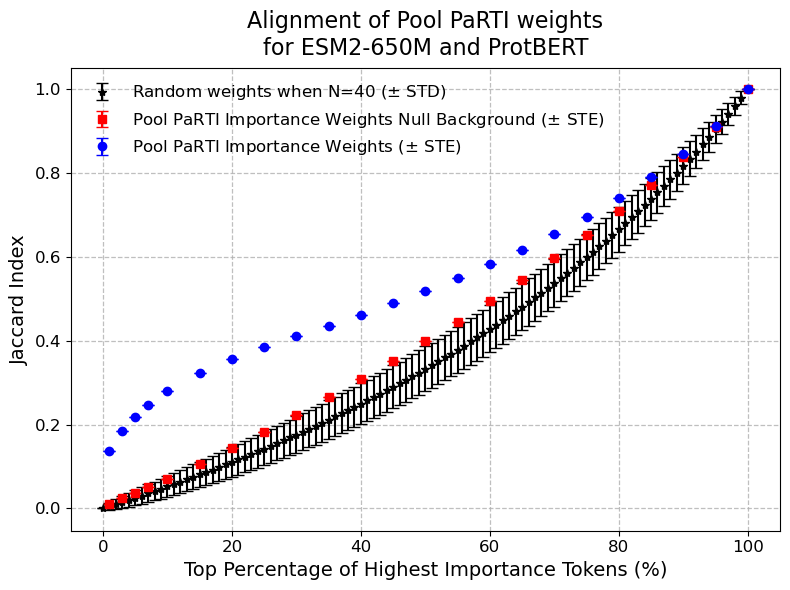

In [122]:
p = np.arange(0, 1.01, 0.01)
jacc = p / (2 - p)
N = 40
jacc_std = np.sqrt(p*(1-p)/(2-p)**2/(N-1))

plt.figure(figsize=(8, 6))  # Use a larger figure size for better resolution

# Theoretical curve
#plt.plot(p * 100, jacc, label='Random Weights', linewidth=2, linestyle='-', color='black')
#plt.plot(p * 100, jacc_std, label='Random Weights', linewidth=2, linestyle='-', color='black')

plt.errorbar(p * 100, jacc, yerr=jacc_std, fmt='*', color='black',
             label=rf'Random weights when N={N} ($\pm$ STD)', capsize=4, markersize=6)

plt.errorbar(p_exp, jac_mean_background_combined, yerr=jac_ste_background_combined, fmt='s', color='red',
             label=r'Pool PaRTI Importance Weights Null Background ($\pm$ STE)', capsize=4, markersize=6)

# Experimental data with error bars

plt.errorbar(p_exp, jac_mean_exp, yerr=jac_ste_exp, fmt='o', color='blue',
             label=r'Pool PaRTI Importance Weights ($\pm$ STE)', capsize=4, markersize=6)

# Customizations for publication quality
plt.legend(fontsize=12, loc='upper left', frameon=False)  # Adjust legend
plt.xlabel('Top Percentage of Highest Importance Tokens (%)', fontsize=14)  # X-axis label
plt.ylabel('Jaccard Index', fontsize=14)  # Y-axis label
plt.title('Alignment of Pool PaRTI weights\nfor ESM2-650M and ProtBERT', fontsize=16, pad=10)  # Add title
plt.grid(which='both', linestyle='--', linewidth=0.9, alpha=0.8)  # Gridlines
plt.xticks(fontsize=12)  # Customize tick font sizes
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping

# Save the figure
plt.savefig('figs/Fig#279#jaccard_index_values_for_ESM2_vs_ProtBERT_N40_and_null_background.png', dpi=300, bbox_inches='tight')  # Save in high resolution


# Show the figure
plt.show()